# Complexity Project - The Oslo Model

Shaun Fendi Gan, February 2020

[CID: 01331868, sfg17@ic.ac.uk] 

* Code for the complexity project are all contained within this jupyter notebook
* Please run chronologically. 
* Oslo Model is an OOP object, each Oslo Model signifies a specific system size L

In [1213]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import zip_longest
from scipy.optimize import curve_fit
from collections import Counter
from scipy import stats

### Oslo Model
Previously, the Oslo model algorithm was such that 
1. slopes would be driven, 
2. slopes would be relaxed changing z configuration. 
3. Check if any slope is larger than their threshold
    * If yes, repeat iteration across all slopes to relax
    * If no, generate new threshold and return to step 1)
    
Although simple, this implementation was extremely inefficient and would begin to face difficulty for system sizes of L > 50. Thus a more calculated approach was taken for the Oslo model, the algorithm goes as follows:

1. Drive slope
2. Relax slope i
3. Append to a list adjacent slopes of i (i.e. i+1, i-1), if z = z_+th + 1 (next_slopes)
    * If i = 1, or i = L, reduce only one neighbouring slope: i= 2 and i = L-1 respectively
4. If next_slopes are not empty, i.e. there are sites to relax, relax sites and repeat 3) if there are unrelaxed slopes. 
5. if next_slopes is empty, generate new random threshold and return to step 1) and drive system

In an edge case, where at site i has z_th of 1, and both site i-1 and site i+1 reduce, this would not reduce the slope sufficiently to be below the threshold. Thus append site i to next_slopes to relax in the following iteration

In [1215]:
class Oslo:
    def __init__(self,L, p =[1/2,1/2]):
        """
        Oslo model class to investigate self organised criticality. 
        All calculations done within class, extracted for analysis in subsequent sections.

        ---------------------------
        |Initialisation Variables:|
        ---------------------------
        L = system size (int)
        p = probabilities of thresholds (list)
        
        -----------------_
        |Class Variables:|
        ------------------
        Oslo.avalanches - list of avalanches at all drives
        Oslo.configurations - list of lists of z configs
        Oslo.delta_hights - list of changes in height at each time
        Oslo.cross_over_time - cross-over time value (int)
        
        """
        self.p = p
        self.L = L

    def run(self, plot=False, N_recurrents=None,title=None, check_slopes = False,N_runs = None):
        """
        Runs code, for driving Oslo Model. 
            
        Saves: z configurations, avalance sizes, cross-over time and changes in height
        
        ###########
        Parameters:
        ###########
        plot: plots final z config in bar graph
        title: Bar Graph title
        N_recurrents: if not none, runs for as many grains specified after recurrent 
        N_runs: if not none, runs for as many grains specified.
        check_slopes: check all slopes above threshold using inbuilt any (TESTING ONLY)
        """
        z = [0] * self.L

        # Allows for change in probabilities
        n = len(self.p)  # Number of thresholds, from probability
        z_ths = np.arange(1, n + 1, 1)  # Generates possible thresholds [1,2,...]

        # Initialisation - generate thresholds for each site
        z_th = [random.choice(z_ths) for x in range(self.L)]

        # Tracking Variables
        end_value = 0 # For counting grains added
        z_avg_steady = [] # List of configurations after cross-over
        crossover = False  # Tracks cross-over
        N_full_avalanche = 0  # Tracks system-size avalanches
        cross_over_time = 0 # Counter for cross-over time
        
        # Store class variables for extraction
        self.avalanches = []
        self.configurations = [[0]*self.L] 
        self.delta_heights = [0]
        self.cross_over_time = 0
        
        # Define variables for different run types (total grains added, or grains added after cross-over)
        if N_runs != None:
            N_count = N_runs
        elif N_recurrents != None:
            N_count = N_recurrents
        
        while end_value < N_count:
            # Drive
            z[0] += 1
            s = 0
            del_h = 1 # Delta height is 1 if no topples at i=1
            slopes_to_relax = [0] # List of initial unrelaxed slopes
            
            # Cross-over time counter
            if crossover == False: cross_over_time += 1
                
            # Relaxation - Checks adjacent slopes z relaxed, before driving again, continue if list not empty
            while len(slopes_to_relax) != 0:
                check_slopes = slopes_to_relax
                next_slopes = []
                
                # Check indexes in list of slopes to relax
                for i in slopes_to_relax:
                    if z[i] > z_th[i]:
                        s += 1 
                        
                        if i == 0: 
                            z[i] = z[i] - 2
                            z[i+1] = z[i+1] + 1
                            
                            if z[i+1] == z_th[i+1] + 1: 
                                next_slopes.append(i+1) # Save slope index if unrelaxed
                            
                            del_h -= 1

                        elif i == len(z) - 1:  
                            z[len(z) - 1] = z[len(z) - 1] - 1
                            z[len(z) - 2] = z[len(z) - 2] + 1
                            
                            crossover = True
                            
                            if z[len(z) - 2] == z_th[len(z) - 2] + 1:
                                next_slopes.append(len(z) - 2) # Save slope index if unrelaxed
                                
                            if self.cross_over_time == 0: 
                                self.cross_over_time = cross_over_time

                        else: 
                            z[i] = z[i] - 2
                            z[i + 1] = z[i + 1] + 1
                            z[i - 1] = z[i - 1] + 1

                            # Save slope index if unrelaxed
                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            if z[i-1] == z_th[i-1] + 1:
                                next_slopes.append(i-1)
                            
                        z_th[i] = random.choice(z_ths)
                        if z[i] > z_th[i]:
                            next_slopes.append(i)
                    else:
                        pass

                if len(next_slopes) > 0:
                    slopes_to_relax = list(set(next_slopes)) # Sorts list
                else:
                    slopes_to_relax = [] # Empty list, thus no more relaxations.
                    
            self.avalanches.append(s)

            # Change run type depending, on N_runs, or N_recurrents
            if crossover == True:
                end_value += 1
                z_avg_steady.append(np.cumsum(z[::-1])[::-1][0])
            elif N_runs != None:
                end_value +=1
            
            # Save changes in height
            self.delta_heights.append(del_h)   
            
            # Save configurations in z
            self.configurations.append(z[:].copy())

            # Additional Check. Default = False, only for testing. 
            if check_slopes == True:
                if any(x > max(z_ths) for x in z) == True:
                    print(z,z_th)
                    print(check_slopes)

                    raise ValueError("Not all sites relaxed")

        # Obtains cumulative sum of slopes, to represent heights
        final_heights = np.cumsum(z[::-1])[::-1]  # indexing to reverse list
        
        self.z = z.copy()
        self.times = np.arange(1,len(self.delta_heights)+1,1)

        if plot == True:
            self._plot_bar(z,title = title)
        
        # Save text files to prevent re-calculations
        np.savetxt("saves/L{}_{}_avalanches.txt".format(self.L,N_count),self.avalanches,fmt="%d")
        np.savetxt("saves/L{}_{}_configurations.txt".format(self.L,N_count),self.configurations,fmt="%d")
        np.savetxt("saves/L{}_{}_delta_heights.txt".format(self.L,N_count),self.delta_heights,fmt="%d")
        np.savetxt("saves/L{}_{}_cross_over_time.txt".format(self.L,N_count),[self.cross_over_time],fmt="%d")
        np.savetxt("saves/L{}_{}_z_avg_steady.txt".format(self.L,N_count),z_avg_steady,fmt="%d")
        return final_heights, z, np.mean(z_avg_steady), self.configurations
    
    def load_data(self,N_count):
        """
        Load data from pre-saved text files. Use this if Oslo.run has previously produced text files.
        """
        self.avalanches = np.loadtxt("saves/L{}_{}_avalanches.txt".format(self.L,N_count),dtype=int)
        self.configurations = np.loadtxt("saves/L{}_{}_configurations.txt".format(self.L,N_count),dtype=int)
        self.delta_heights = np.loadtxt("saves/L{}_{}_delta_heights.txt".format(self.L,N_count),dtype=int)
        self.cross_over_time = int(np.loadtxt("saves/L{}_{}_cross_over_time.txt".format(self.L,N_count),dtype=int))
        
        z_avg_steady = np.loadtxt("saves/L{}_{}_z_avg_steady.txt".format(self.L,N_count),dtype=int)

        self.z = self.configurations[-1].copy()
        self.times = np.arange(1,len(self.delta_heights)+1,1)

        final_heights = np.cumsum(self.z[::-1])[::-1]  # indexing to reverse list
        
        return final_heights, self.z, np.mean(z_avg_steady), self.configurations
    
    def get_heights(self,plot = True):
        """
        Calculates heights pile at all times from finding sum of changes in height.
        
        Params:
        plot: plots final z config in bar graph
        
        Returns: 
        time: one list of times
        heights: list of heights, at all times
        """
        heights = np.cumsum(self.delta_heights)
        time = self.times.copy()
        
        if plot == True:
            plt.xlabel("Time")
            plt.ylabel("Height")
            plt.title("Height of pile against time")
            plt.plot(time,heights,label = "L = {}".format(self.L))
        return time, heights

    def get_heights_attractor(self,plot = False):
        """
        Finds average height of system after reaching recurrent. 
        
        Params:
        plot: plots final z config in bar graph
        
        Returns 
        avg_height: average height after reaching recurrent
        """
        times, heights = self.get_heights(plot = False)
        
        # Finds cross-over time
        times_crossed = times[self.cross_over_time:]
        # Shift so T starts at zero
        times_crossed -= self.cross_over_time
        # Find heights crossed after cross-over
        heights_crossed = heights[self.cross_over_time +1:]
        heights_crossed = np.array([float(h) for h in heights_crossed])
        
        # Calcule values used for std dev and mean height
        avg_height = 1/float(times_crossed[-1]) * sum(heights_crossed)
        avg_height_sq = 1/float(times_crossed[-1]) * sum(heights_crossed**2)
        
        # Saves standard deviation
        self.std_dev = np.sqrt(avg_height_sq - avg_height **2)
        
        if plot == True:
            plt.plot(times_crossed,heights_crossed)
        return avg_height
    
    def get_std_heights(self):
        # Returns standard deviation of heights
        return self.std_dev
    
    def get_cross_over_times(self):
        # Returns cross-over time
        return self.cross_over_time

    def get_probability_heights(self):
        """
        Calculate height probabilities, for all times after recurrent
        
        Returns: a list of normalised probabilities from height = 0
        """
        # Calculate heights in attractor
        sums = [sum(x) for x in self.configurations][self.cross_over_time +1:]
        
        # Find configurations after cross-over
        configurations = self.configurations[self.cross_over_time +1:]
        
        # Count number of unique heights
        counts = (dict(Counter(str(e) for e in sums)))
        
        # dtype management
        N_observed = sum(counts.values())
        count_heights = np.array(list(counts.values()))
        heights = (list(counts.keys()))
        heights = [int(h) for h in heights]

        # Calculate Probability
        probs = count_heights/N_observed

        return [heights,probs]

    def get_avalanches_crossed(self):
        # Finds avalanches after cross-over
        avalanches_crossed = self.avalanches.copy()[self.cross_over_time +1:]
        return avalanches_crossed
    
    def get_k_moment(self,k = [1,2,3,4]):
        """
        Calculates avalanche moment for k = 1,2,3,4
        
        Return: a list of <s^k> for all specified k values. (Default: len = 4)
        """
        # Must use np.float64 to account for overflow error
        avalanches_crossed = self.avalanches.copy()[self.cross_over_time +1 :]
        avg_s = [sum(np.array(np.float64(avalanches_crossed))**k)/len(avalanches_crossed) for k in k]
        return avg_s
    
    def _plot_bar(self,z,title = "Oslo Model"):
        # Plot bar graph given configurations
        heights = np.cumsum(z[::-1])[::-1] #indexing to reverse list
        plt.figure(figsize= (8,5))
        plt.bar(np.arange(1,len(z)+1,1),heights)
        plt.title(title)
        plt.ylabel("Heights")
        plt.xlabel("sites")
        
# Check all functions in class work

# check = Oslo(4)
# a,b,c,configs = check.run(plot = False,N_recurrents = 100)
# # a,b,c,configs = check.run(plot = True,N_runs = 100)
# # a,b,c,configs = check.load_data(100)
# a,b = check.get_heights()
# check.get_heights_attractor()
# check.get_probability_heights()
# check.get_avalanches_crossed()
# check.get_k_moment()
# check.get_std_heights()
# check.get_cross_over_times()

In [1100]:
# help(Oslo)

## 1 Implementation of the Oslo model (Tests) 

### 1.1. Test 1: Expected Heights at site i =1
For p = 1/2, we expect the mean height for the first site to be around
* 26.5 for L = 16, and 
* 53.9 for L = 32

In [1130]:
# Test 1, height_1 (L==16) = 26.5
Oslo_16 = Oslo(16)
avg_h1 = Oslo_16.run(N_recurrents=1000000,check_slopes = True)[2]

print("Expected = {}, Model = {:.2f}, {:.2f}%".format(26.5,avg_h1,(avg_h1 - 26.5)/26.5 * 100))

# Test 2, height_1 (L==32) = 53.9
Oslo_32 = Oslo(32)
avg_h2 = Oslo_32.run(N_recurrents=1000000)[2]
print("Expected = {}, Model = {:.2f}, {:.2f}%".format(53.9,avg_h2,(avg_h2 - 53.9)/53.9 * 100))

Expected = 26.5, Model = 26.53, 0.12%
Expected = 53.9, Model = 53.89, -0.02%


### 1.2 Test 2: Reduction to BTW Model (d=1)
For p=1, this should reduce back to the BTW model for d=1, where grains are only added at i=1. BTW does not account for possible spatial and temporal fluctuations, thus the steady state of the system should occur after a grain takes avalanche steps equal to the number of sites. 

This was shown from the test below

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Expected = 16, Model = 0.00


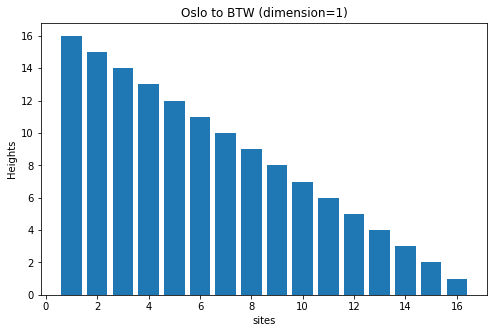

In [12]:
# Test 3, p = 1, z_th = [1], Recurrent state should be L = 16
BTW = Oslo(16,p = [1])
BTW.run(plot= True,N_recurrents = 10,title = "Oslo to BTW (dimension=1)")
time,height = BTW.get_heights(plot = False)
print("Expected = {}, Model = {:.2f}".format(16,height[0]))

### 1.3. Test 3: Recurrent Configurations

A recurrent configuration means that the system has reached a steady state, as it only occurs after all transient configurations have occured. These will occur with a frequency greater than one. 

For the Oslo model, we expect N_R to be 5 for L = 2

In [1129]:
L = 1
N_S = 3**L

def N_R(L):
    phi = (1+np.sqrt(5))/2
    N_R = 1/np.sqrt(5)* (phi *(1+phi)**L + 1/(phi * (1+phi)**L))
    return N_R

# Oslo  L = 2
Oslo_2 = Oslo(2,p = [0.5,0.5])
a,b,c,configurations = Oslo_2.run(plot= False,N_recurrents = 50000)

counts = (Counter(str(e) for e in configurations)) # Create dictionary counts
N_R = Counter(el for el in counts.elements() if counts[el] > 1) # Counts configs that occur more than once
print(N_R)
print("--N_R for L = 2 :",len(N_R),"\n")

# Oslo L = 4
Oslo_4 = Oslo(4,p = [0.5,0.5])
a,b,c,configurations = Oslo_4.run(plot= False,N_recurrents = 50000)

counts = (Counter(str(e) for e in configurations))
N_R = Counter(el for el in counts.elements() if counts[el] > 1)
print(N_R)
print("--N_R for L = 4 :",len(N_R))


Counter({'[1, 2]': 18677, '[2, 2]': 12505, '[2, 1]': 9319, '[1, 1]': 4766, '[0, 2]': 4735})
--N_R for L = 2 : 5 

Counter({'[1, 1, 2, 2]': 6472, '[1, 2, 2, 2]': 5850, '[1, 2, 1, 2]': 5309, '[2, 1, 2, 2]': 5158, '[2, 2, 1, 2]': 3901, '[2, 2, 2, 2]': 3129, '[1, 2, 2, 1]': 2672, '[2, 1, 1, 2]': 2579, '[0, 2, 2, 2]': 2558, '[2, 2, 2, 1]': 1961, '[1, 1, 1, 2]': 1643, '[0, 2, 1, 2]': 1351, '[0, 1, 2, 2]': 1296, '[2, 1, 2, 1]': 1294, '[2, 0, 2, 2]': 1287, '[1, 1, 2, 1]': 803, '[0, 2, 2, 1]': 647, '[1, 0, 2, 2]': 634, '[2, 2, 1, 1]': 322, '[2, 2, 0, 2]': 315, '[1, 2, 0, 2]': 224, '[1, 2, 1, 1]': 203, '[2, 0, 1, 2]': 111, '[0, 1, 1, 2]': 97, '[0, 1, 2, 1]': 49, '[2, 0, 2, 1]': 46, '[2, 1, 1, 1]': 26, '[2, 1, 0, 2]': 20, '[0, 2, 0, 2]': 13, '[0, 2, 1, 1]': 11, '[1, 1, 0, 2]': 9, '[1, 0, 1, 2]': 7, '[1, 1, 1, 1]': 6, '[1, 0, 2, 1]': 4})
--N_R for L = 4 : 34


## 2. Height of the Pile $h(t;L)$

Everytime a grain is added to the pile, the count it increased by one. Everytime the final pile is reached, the count is reduced by negative one. Reduce by -1 as allows for multiple avalanches caused by one grain that could reduce the heights further.

Height of the pile $h(t;L)$is defined as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $z_i(t)$ are the slopes. This essentially finds the sum of all the slopes, to find the height of the first pile.



### Task 2a 
Increasing the size of the system, would increase the number of recurrent configurations, as seen from the plot below. Recurrent configurations occur when the height of the pile begins to fluctuate around a certain value. 

When the system is in the transient state, the height continues to increase exponentially against time, where as it plateaus or fluctuates about a certain value once it has entered the recurrent state. 

In [342]:
# System sizes, used throughout code.
sizes = np.array([4,8,16,32,64,128,256,512])
Oslo_models = [Oslo(L) for L in sizes]

[array([0, 1, 1, ..., 6, 7, 8]), array([ 0,  1,  1, ..., 13, 14, 14]), array([ 0,  1,  2, ..., 28, 27, 26]), array([ 0,  1,  2, ..., 56, 56, 57]), array([  0,   1,   1, ..., 107, 108, 108]), array([  0,   1,   1, ..., 219, 219, 219]), array([  0,   1,   2, ..., 445, 441, 440]), array([  0,   1,   2, ..., 887, 887, 886])]


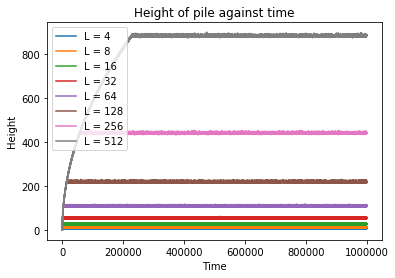

In [344]:
times_sample = []
heights_sample = []

for Oslo_L in Oslo_models:
    print(Oslo_L)
    Oslo_L.run(N_runs = 1000000)
#     Oslo_L.load_data(1000000)
#     Oslo_L.run(N_recurrents = 1000)
    time,height = Oslo_L.get_heights()
    times_sample.append(time)
    heights_sample.append(height)
plt.legend()

print(heights_sample)

### Task 2b
Cross-over time is the number of grains $\textbf{before}$ an added grain induces a grain to leave the system. It is seen as $t_c(L)$:
$$t_c(L) = \sum_{i=1}^{L} z_i  i$$

where $z_i$ are the local slopes in the system to which an added grain induces a flow out of the system for the first time.

Numerically add to t_c, until you enter the last site.  

* Done only for L = 256 for time

4
8
16
32
64
128
256
256 N =  0
256 N =  1
256 N =  2
256 N =  3
256 N =  4
256 N =  5
256 N =  6
256 N =  7
256 N =  8
256 N =  9
256 N =  10
256 N =  11
256 N =  12
256 N =  13
256 N =  14
256 N =  15
256 N =  16
256 N =  17
256 N =  18
256 N =  19
256 N =  20
256 N =  21
256 N =  22
256 N =  23
256 N =  24
256 N =  25
256 N =  26
256 N =  27
256 N =  28
256 N =  29
256 N =  30
256 N =  31
256 N =  32
256 N =  33
256 N =  34
256 N =  35
256 N =  36
256 N =  37
256 N =  38
256 N =  39
256 N =  40
256 N =  41
256 N =  42
256 N =  43
256 N =  44
256 N =  45
256 N =  46
256 N =  47
256 N =  48
256 N =  49
256 N =  50
256 N =  51
256 N =  52
256 N =  53
256 N =  54
256 N =  55
256 N =  56
256 N =  57
256 N =  58
256 N =  59
256 N =  60
256 N =  61
256 N =  62
256 N =  63
256 N =  64
256 N =  65
256 N =  66
256 N =  67
256 N =  68
256 N =  69
256 N =  70
256 N =  71
256 N =  72
256 N =  73
256 N =  74
256 N =  75
256 N =  76
256 N =  77
256 N =  78
256 N =  79
256 N =  80
256 N =  81
256 N

Text(80, 1000, 'gradient = 1.971183')

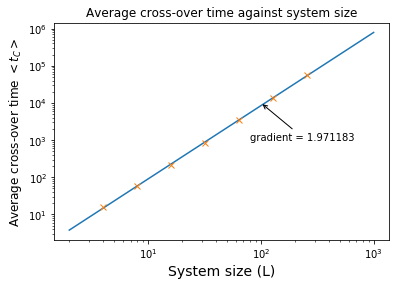

In [1201]:
idx = len(sizes)-1 # Up to L = 256 for time

crossover_avgs = []
for oslo_test in [Oslo(L) for L in sizes[:idx]]:
    print(oslo_test.L)
    times = []
    for N in range(100):
        if oslo_test.L > 128:
            print(oslo_test.L, "N = ",N)
        oslo_test.run(N_recurrents = 1)
        times.append(oslo_test.get_cross_over_times())
    avg_time = np.mean(times)
    crossover_avgs.append(avg_time)
    
m,c,a,a,a = stats.linregress(np.log10(sizes[:idx]),np.log10(crossover_avgs[:idx]))


print("Cross-over time ~ L^{:.7f}, calculated for L >= {}".format(m,sizes[idx]))

samp_x = np.arange(2,1000,1)

plt.figure()
plt.loglog(samp_x,samp_x**m*10** c)
plt.plot(sizes[:idx],crossover_avgs,'x')
plt.xlabel("System size (L)",fontsize = 14)
plt.ylabel("Average cross-over time $<t_C>$",fontsize = 12)
plt.title("Average cross-over time against system size")
plt.annotate('gradient = {:.6f}'.format(m), xy=(100, 10000), xycoords='data',
            xytext=(80, 1000), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

#### Corrections to scaling for $\langle t_C \rangle$

Text(0.5, 1.0, 'Corrections to Scaling for cross-over time')

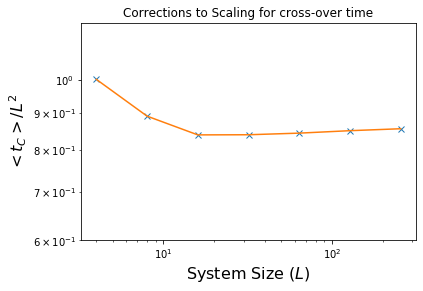

In [1202]:
plt.loglog(sizes[:idx],[crossover_avgs[:idx][i]/sizes[:idx][i]**2 for i in range(len(sizes[:idx]))],'x')
plt.loglog(sizes[:idx],[crossover_avgs[:idx][i]/sizes[:idx][i]**2 for i in range(len(sizes[:idx]))])
plt.ylabel(r"$<t_C>/L^2$",fontsize = 16)
plt.xlabel(r"System Size $(L)$",fontsize = 16)
plt.ylim(0.6,1.2)
plt.title("Corrections to Scaling for cross-over time")

Verify cross-over time by plotting occurence in time

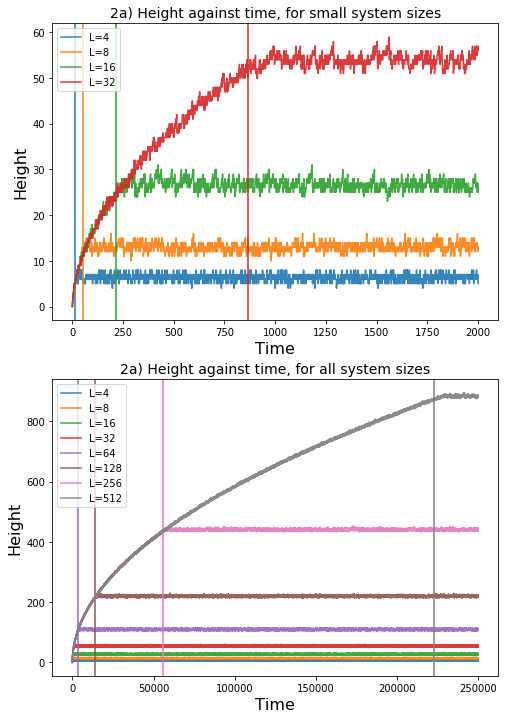

<Figure size 432x288 with 0 Axes>

In [455]:
fig,(ax2,ax1) = plt.subplots(2,1,figsize= (8,12))

end = 250000
for i in range(len(Oslo_models)):
    ax1.plot(times_sample[i][:end],heights_sample[i][:end],alpha = 0.9,label = "L={}".format(sizes[i]))
    if i>3:
        ax1.axvline(crossover_avgs[i],color = "C{}".format(i))

ax1.set_xlabel("Time",fontsize = 16)
ax1.set_ylabel("Height",fontsize = 16)
ax1.set_title("2a) Height against time, for all system sizes",fontsize = 14 )
ax1.legend()

plt.figure()
end = 2000
for i in range(len(Oslo_models[:4])):
    ax2.plot(times_sample[i][:end],heights_sample[i][:end],alpha = 0.9,label = "L={}".format(sizes[i]))
    ax2.axvline(crossover_avgs[i],color = "C{}".format(i))

ax2.set_xlabel("Time",fontsize = 16)
ax2.set_ylabel("Height",fontsize = 16)
ax2.set_title("2a) Height against time, for small system sizes",fontsize = 14)
ax2.legend()

### Task 2c: Height, Cross-over Time - L Dependance

a. Considering the height of the pile $h(t;L)$ as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $L$ is the length/size of the system, $z_i$ is the slope at site $i$ and $t$ is time or number of grains added to system since the start. We can approximate all the slopes at all sites $i$ in the above equation as an average value. This reduces the equation to

$$\begin{equation}\begin{aligned} h(t;L) &= \sum^L_{i=1}<z> \\&= L \cdot <z>  \\ \Rightarrow h(t;L) &\propto L\end{aligned}\end{equation}$$


thus showing that $h(t;L) \propto L$ in a linear relationship.

b. Similarly for cross-over time, we have the following relation

$$t_c(L) = \sum^L_{i=1} z_i \cdot i$$

where $t_c(L)$ is the cross-over time. We can perform the same apprroximation of averaging all the slopes, to remove the slopes from the sum. Applying the arithmetic sum formula $S_n = \frac{N(N+1)}{2}$, we obtain


$$\begin{equation}\begin{aligned} t_c(L) &= <z> \cdot \sum^L_{i=1}  i \\ &=  <z> \cdot \frac{L(L+1)}{2} \approx <z> \cdot L^2 \\ \Rightarrow t_c(L) &\propto L^2 \end{aligned}\end{equation}$$

showing cross-over time approximated as a quadratic relation.


### Task 2d: Finite Scaling Ansatz
The somewhat counterintuitive idea behind finite-size scaling is to use the dependence of measured properties on finite system size to extract critical exponents for the infinite system.

$$h(t;L)\propto L^{\tau}\mathcal{F}\Big(\frac{t}{t_C}\Big)$$

where define $x = \frac{t}{t_C}$

We can also describe cross-over time as 

$$ t_C \propto L^D $$

where $L$ is the length of the system and D is another critical exponent

From the situation in Task 2c), we expect $h \sim L$ and $t_C \sim L^2$, indicating $\tau \sim 1$ and $D \sim 2$. 

Smooth out the data using

$$\tilde h(t;L) = \frac{1}{M} \sum^M_{j=1} h^j(t;L) $$
From analysing the log plots of heights, we can see that the scaling ansatz should follow

$$\mathcal{F} \propto \left\{\begin{array}{ll}
{\text{increase exponentially}} & {\text { if } t\ll t_C \text{ (or }x \ll 1)} \\
{\text{constant}} & {\text { if } t \gg t_C \text{ (or } x \gg 1)} 
\end{array}\right.$$

In [1110]:
heights = [] # List of lists Heights for all models
crossovers_avg = [] # Average Cross-over times

for Oslo_L in Oslo_models:
    heights_full = []
    crossovers = []
    
    for N in range(10):
        time,heights_L = Oslo_L.get_heights(plot = False)
        crossovers.append(Oslo_L.get_cross_over_times())
        heights_full.append(np.array(heights_L))
        
    # Find average height over time
    height = list(sum(heights_full)/len(heights_full))
    height.remove(height[0]) 
    
    # -1 to conserve index as first height removed
    crossover = int(np.mean(crossovers) - 1)
    
    # Store values
    heights.append(height)
    crossovers_avg.append(crossover)
    
print("Cross-over times", crossovers_avg)

Cross-over times [15, 54, 215, 863, 3418, 14043, 55955, 222966]


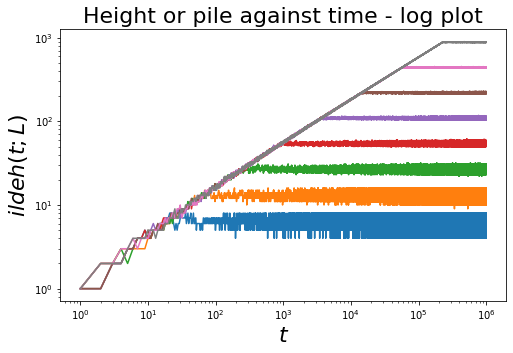

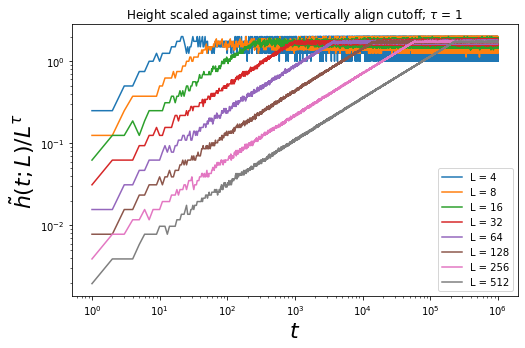

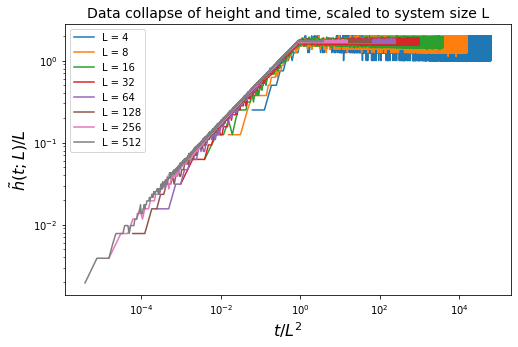

In [1189]:
tau = 1
D = 2

times = [np.arange(1,len(height)+1,1) for height in heights]

# Heights/L
heights_L = [heights[i] / sizes[i]**tau for i in range(len(sizes))]

# Times/L
times_L = [times[i]/ sizes[i]**D for i in range(len(sizes))]

#Plotting
plt.figure(figsize = (8,5))
plt.title("Height or pile against time - log plot",fontsize = 22)
plt.ylabel(r"$\tilde{h}(t;L)$",fontsize = 22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(tau))
plt.ylabel(r"$\tilde{h}(t;L) / L^{\tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights_L[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

plt.figure(figsize = (8,5))
plt.title("Data collapse of height and time, scaled to system size L",fontsize = 14)
plt.ylabel(r"$\tilde{h}(t;L) / L$",fontsize =16)
plt.xlabel(r"$t/L^2$",fontsize = 16)
[plt.loglog(times_L[i],heights_L[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

time exponent values: [0.7188034556918816, 0.6547284144293857, 0.5758009306734283, 0.5506961518310862, 0.5313206537406915, 0.5187262648130613, 0.5109726018526317, 0.5064033944628966]

Height varies with time following exponent of t^0.5064


Text(0, 0.5, 'Gradient of Transient for height vs. time')

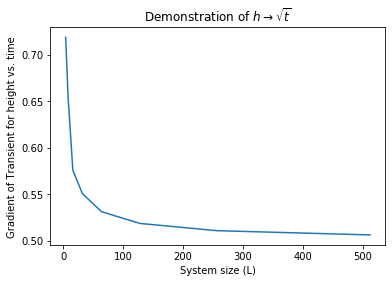

In [1028]:
gradients = []
ints = []
cc = crossovers_avg # Rename for conciseness

for i in range(len(heights_L)):
    x = np.log10(times_L[i])[:cc[i]]
    y = np.log10(heights_L[i])[:cc[i]]
    m,c,a,a,a = stats.linregress(x,y)
    gradients.append(m)
    ints.append(c)

tau_t = gradients[-1] # Take exponent as final value

print("time exponent values:",gradients)
print("\nHeight varies with time following exponent of t^{:.4f}".format(tau_t))

plt.plot(sizes,gradients)
plt.title(r"Demonstration of $h \rightarrow \sqrt{t}$")
plt.xlabel("System size (L)")
plt.ylabel("Gradient of Transient for height vs. time")

Perform data collapse for height with time, instead of L

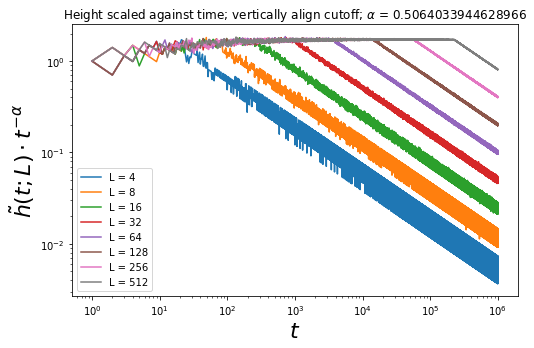

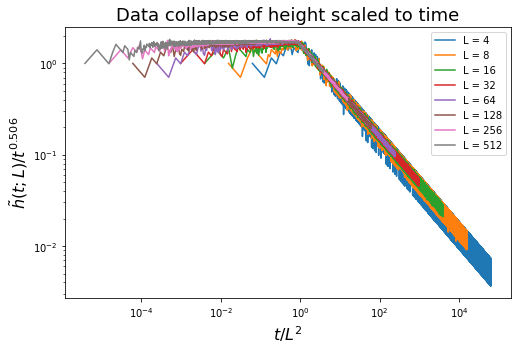

In [1192]:
D = 2

# Calculate scaled values for height to time. 

# t^-tau
times_tau = [np.array(list(map(float,times[i]))) ** (-tau_t) for i in range(len(times))]
# h/t^tau
heights_t = [heights[i] * times_tau[i] for i in range(len(heights))]

# Plot
plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\alpha$ = {}".format(tau_t))
plt.ylabel(r"$\tilde{h}(t;L) \cdot t^{- \alpha}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

plt.figure(figsize = (8,5))
plt.title(r"Data collapse of height scaled to time",fontsize = 18)
plt.xlabel(r"$t / L^2$",fontsize = 16)
# plt.ylabel(r"$\tilde{h}(t;L)$ / t^{}".format(tau_t),fontsize =16)
plt.ylabel(r"$\tilde{h}(t;L) / t^{0.506}$",fontsize =16)
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

### Task 2e: $a_0$ and $\omega_1$

Estimate $a_o$ and $\omega_1$ due to the corrections to scaling

In [591]:
def avg_gradient_log(x,y,ints_return = False):
    """
    Finds the average gradient on a log scale. 
    
    Parameters: 
    x and y axis values (non log values)
    ints_return: returns intercepts too
    
    Returns: a gradient value from a log plot, (or intercepts too)
    """
    gradients = []
    ints = []
    
    y = np.log10(y)
    x = np.log10(x)
    for i in range(len(x)):
        for j in range(len(x)):
            if i != j:
                m = (y[i] - y[j] )/ (x[i]  - x[j])
                c = y[i] - m*x[i]
                gradients.append(m)
                ints.append(c)
                
    if ints_return == True:
        return np.mean(gradients),np.mean(ints)
    else:
        return np.mean(gradients)

def _chi_square(x,y):
    """
    Calculates chi-square for a given set of x-y values, compared to a 
    straight line fit. 
    
    Parameters: x and y axis values
    Returns: Sum of chi-square values
    """
    m = (y[-1] - y[0]) / (x[-1] - x[0])
    c = y[0] - m*(x[0])

    expected_y = [m*x_i + c for x_i in x]

    chi = [(y[i] - expected_y[i])**2 / expected_y[i] for i in range(len(y))]
    return sum(chi)

In [1154]:
avg_heights = [x.get_heights_attractor(plot = False) for x in Oslo_models]
avg_heights_L = np.array([avg_heights[i]/sizes[i] for i in range(len(sizes))]) # <h> / L

print(avg_heights_L)

# Generate a list of a_o values
del_a =0.000001
a_o = np.arange(max(avg_heights_L) + del_a,1.8,del_a)

# Generate y values for different a_o predictions
y_s = [1 - np.array(avg_heights_L)/a for a in a_o]
x = sizes

# Find Absolute Chi Square Values
chis = []
for y in y_s:
    chis.append(abs(_chi_square(np.log(x),np.log(y))))
    
# Find min a_o
min_a_o = a_o[np.argmin(chis)]

# Generate finalised y values for best a_o
y = 1 - np.array(avg_heights_L)/min_a_o
gradient,ints = avg_gradient_log(x,y,ints_return = True)

print("a_o = {:.4f}, w_1 = {:.4f}".format(min_a_o,-np.mean(gradient)))

[1.57779217 1.62239523 1.65821477 1.6840545  1.70138283 1.71318193
 1.7207095  1.72513138]
a_o = 1.7369, w_1 = 0.5476


Average slope is not a_0 at small L, so requires corrections to scaling


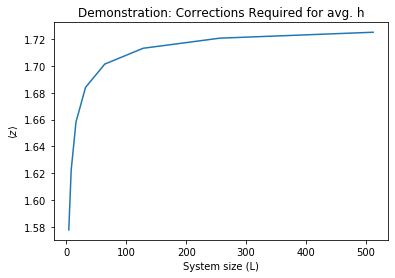

In [1199]:
plt.plot(sizes,avg_heights_L)
plt.ylabel(r"$\langle z \rangle$")
plt.xlabel("System size (L)")
plt.title("Demonstration: Corrections Required for avg. h")

print("Average slope is not a_0 at small L, so requires corrections to scaling")

(0.15, 0.25)

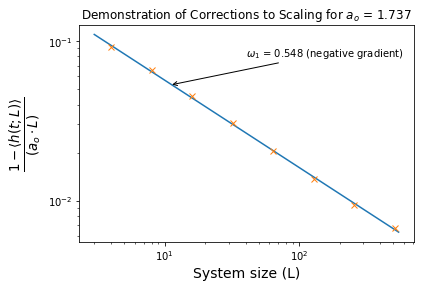

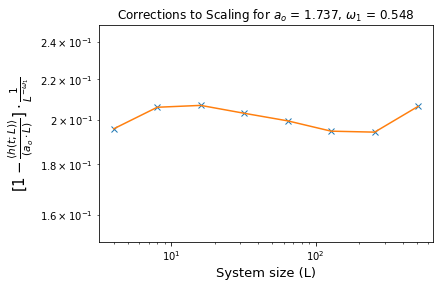

In [1210]:
# Plot

samp_x = np.arange(3,550,1)

plt.figure()
plt.title("Demonstration of Corrections to Scaling for $a_o$ = {:.3f}".format(min_a_o))
plt.loglog(samp_x,samp_x**gradient*10**ints)
plt.loglog(x,1 - np.array(avg_heights_L)/min_a_o,'x')
plt.ylabel(r"$\frac{1-\langle h(t;L) \rangle }{(a_o \cdot L)}$",fontsize = 19)
plt.xlabel("System size (L)",fontsize = 14)


plt.annotate(r'$\omega_1$ = ${:.3f}$ (negative gradient)'.format(-gradient), xy=(11, 0.053), xycoords='data',
            xytext=(40, 0.08), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

# Corrections to scaling for higher order exponents and constants
y_c = [(1 - np.array(avg_heights_L[i])/min_a_o)/(sizes[i]**np.mean(gradient)) for i in range(len(sizes))]

plt.figure()
plt.title("Corrections to Scaling for $a_o$ = {:.3f}, $\omega_1$ = {:.3f}".format(min_a_o,-np.mean(gradient)))
# plt.loglog(samp_x,samp_x**gradient*10**ints)
plt.plot
plt.loglog(sizes,y_c,'x')
plt.loglog(sizes,y_c)
plt.ylabel(r"$[ 1-\frac{\langle h(t;L) \rangle }{(a_o \cdot L)}] \cdot \frac{1}{L^{-\omega_1}}$",fontsize = 15)
plt.xlabel("System size (L)",fontsize = 13)

plt.ylim(0.15,0.25)


The process above essentially works to minimise the Chi-square plot below, In order to find the value of $a_o$ that is the smallest

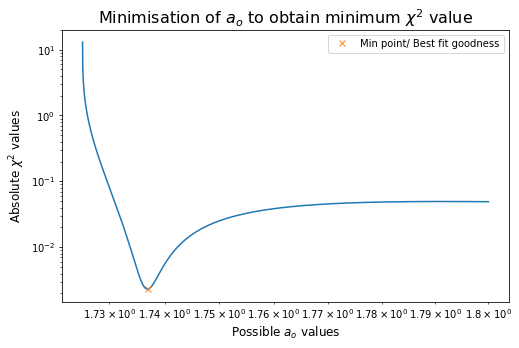

In [1161]:
plt.figure(figsize=(8,5))
plt.title(r"Minimisation of $a_o$ to obtain minimum $\chi^2$ value",fontsize = 16)

plt.loglog(a_o,chis)
plt.loglog(a_o[np.argmin(chis)],min(chis),'x',label = "Min point/ Best fit goodness")

plt.xlabel("Possible $a_o$ values",fontsize = 12)
plt.ylabel("Absolute $\chi^2$ values",fontsize = 12)
plt.legend()

### Task 2f: $\sigma_h$ scaling against system size

Thus power law as log plot is linear, exponent =  0.25315852134087197


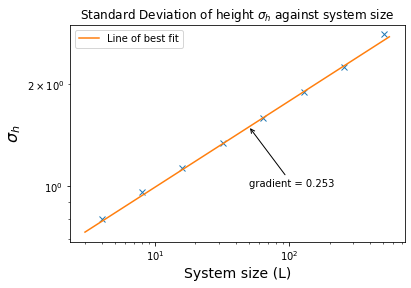

In [1211]:
std_heights = [x.get_std_heights() for x in Oslo_models]


gradients,inter = avg_gradient_log(sizes,std_heights,ints_return = True)

print("Thus power law as log plot is linear, exponent = ",gradients)

samp_x = np.arange(3,560,1)

plt.figure()
plt.loglog(sizes,std_heights,"x")
plt.loglog(samp_x,samp_x**gradients*10**inter,label="Line of best fit")
plt.xlabel("System size (L)",fontsize = 14)
plt.ylabel("$\sigma_h$",fontsize = 16)
plt.title("Standard Deviation of height $\sigma_h$ against system size")

plt.annotate('gradient = {:.3f}'.format(gradients), xy=(50, 1.5), xycoords='data',
            xytext=(50,1), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
plt.legend()

Average slope = $\langle h \rangle/L \rightarrow a_o$ as $L \rightarrow \infty$, thus its standard deviation tend to zero. 


#### Corrections to Scaling $\sigma_h$

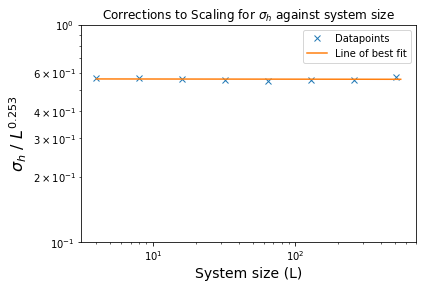

In [1151]:
samp_x = np.arange(4,550,1)
m,c,a,a,a = stats.linregress(np.log10(sizes)[:idx],np.log10([std_heights[i]/sizes[i]**gradients for i in range(len(std_heights))]))

plt.figure()
plt.loglog(sizes,[std_heights[i]/sizes[i]**gradients for i in range(len(std_heights))],'x',label="Datapoints")
plt.loglog(samp_x,samp_x**m*10**c,label="Line of best fit")
plt.xlabel("System size (L)",fontsize = 14)
plt.ylabel("$\sigma_h$" + " / $L^{0.253}$",fontsize = 16)
# plt.ylabel("$\sigma_h$" + " / $L^{:.2f}$".format(gradients),fontsize = 16)
plt.title("Corrections to Scaling for $\sigma_h$ against system size")
plt.ylim(0.1,1)
plt.legend()

## (Extra: Investigating Slope Values)

Consider threshold slopes, slopes of threshold 2 can have more time having that threshold, as more grains can fall into that site, without a new threshold being randomly generated. threshold 2 can hold 2, threshold 1 can hold 1, thus longer. Since it requires more grains to topple, it is more likely for a site to have a threshold of 2 rather than 1, because a slope exceeding a threshold of 1 is more likely to be exceeded, and generate a new slope threshold. 

As it tends to the recurrent state, more and more slopes fall into this situation of being more likely to have slope thresholds of z_th=2, compared to z_th=1, due to the time spent in z_th=2 to be longer. Thus we would expect to see that the ratio of slopes of z =2 and z=1, gradually increase as it approaches cross-over time until it reaches an equilibrium. In fact this is what we see.  

As it enters recurrent, a large proportion of these slopes already have threshold of 2, and since grains are only added from site i=1, these slopes with threshold 2 are all less likely to be reset, causing more slopes in z=2. thus leading to a positive skew in the heights. 

after cross over, see like a sudden rise in ratio of z=2 to z=1, because more slopes are generated to z_th = 2. 

4


Text(0, 0.5, '$\\frac{N(z=2)}{N(z=1)}$')

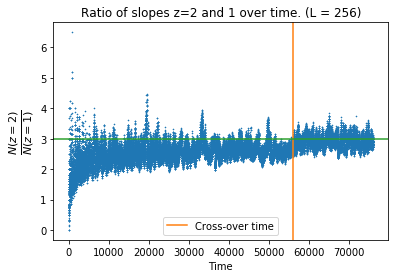

In [736]:
idx = 6
test_cross = Oslo_models[idx].cross_over_time

ratios = []
# Counter([1,2,3],Oslo_models[1].configurations[t])
count = 0
for t in range(test_cross+20000):
    count_1 = Oslo_models[idx].configurations[t].count(1)
    count_2 = Oslo_models[idx].configurations[t].count(2)
    try:
        ratio = count_2/count_1
        ratios.append(ratio)
    except:
        count+=1
        pass
    
print(count)
plt.figure()

plt.title("Ratio of slopes z=2 and 1 over time. (L = {})".format(sizes[idx]))
plt.plot(np.arange(1,len(ratios)+1,1),ratios,'x',ms = 1)
plt.axvline(test_cross-count,color = "C1",label = "Cross-over time")
plt.axhline(3,color = "C2")
plt.legend()

plt.xlabel("Time")
plt.ylabel(r"$\frac{N(z=2)}{N(z=1)}$",fontsize = 16)

## (Extra: Average Slope Value)

All slopes should tend to same $z$ if expected to be identical at $L \gg1$

Text(0.5, 0, 'Site Index')

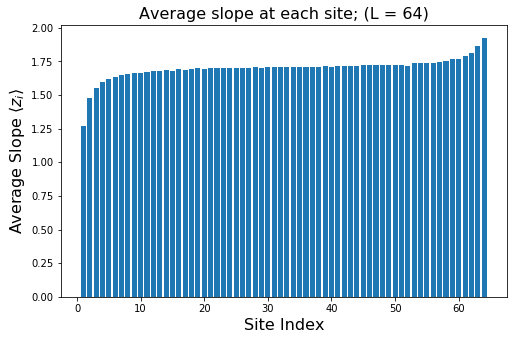

In [893]:
idx2 = 4
configs = Oslo_models[idx2].configurations#[:900000]
distribution = [sum(i) for i in zip(*configs)]
means = [x/1e6 for x in distribution]

plt.figure(figsize = (8,5))
plt.title("Average slope at each site; (L = {})".format(sizes[idx2]),fontsize = 16)
plt.bar(np.arange(1,len(means)+1,1),means)
plt.ylabel(r"Average Slope $\langle z_i \rangle$",fontsize = 16)
plt.xlabel("Site Index",fontsize = 16)

## (Extra: N(odd) to N(even) configurations

In [1009]:
for idx in range(len(sizes)-3):
    configs = Oslo_models[idx].configurations

    sum_configs = [sum(config) for config in configs]

    even =0
    odd =0

    for i in range(len(sum_configs)):
        if sum_configs[i]%2 ==0:
            even+=1
        elif sum_configs[i]%1 ==0:
            odd+=1
    print("L = {}: odd = {},even ={}".format(sizes[idx],odd,even))
    
print("\nEven/Odd configs roughly same, so untrue that there are more odd configs to cause zigzag in small s")

L = 4: odd = 476141,even =523860
L = 8: odd = 505101,even =494900
L = 16: odd = 497967,even =502034
L = 32: odd = 499696,even =500305
L = 64: odd = 500129,even =499872

Even/Odd configs roughly same, so untrue that there are more odd configs to cause zigzag in small s


### Task 2g: Data Collapse of Height probability to height

In [1083]:
# Calculate height probabilities
values = [x.get_probability_heights() for x in Oslo_models]
heights = [values[i][0] for i in range(len(values))]
probs = [values[i][1] for i in range(len(values))]

Since P ~ Gaussian

$$ P(h;L) = \frac{1}{\sigma_h\sqrt{2\pi}} \exp \Big[- \frac{1}{2} \Big(\frac{h - \langle h\rangle}{\sigma_h}\Big)^2\Big] $$

Key thing here is scaling the x component, that is the height component. Thus subtracting the average height$\langle h \rangle$ and dividing by the standard deviation $\sigma_h$.



Text(0.5, 1.0, 'Data Collapse of $P(h;L)$ with $h$')

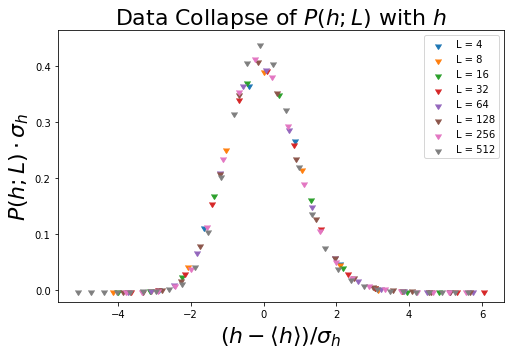

In [987]:
# new_ to signify collapsed values
new_heights = []
new_probs = []

plt.figure(figsize=(8,5))
for i in range(len(heights)):
    # Collapse values
    x = (( heights[i] - avg_heights[i] )/ (std_heights[i]))
    y = probs[i] * std_heights[i]#/ max(probs[i])

    plt.plot(x,y,'x',label = "L = {}".format(sizes[i]),marker = matplotlib.markers.CARETDOWNBASE)
        
    new_heights.append(x)
    new_probs.append(y)
    
plt.legend()
plt.ylabel("$P(h;L) \cdot \sigma_h$",fontsize = 22)
plt.xlabel(r"$(h - \langle h\rangle)/\sigma_h$",fontsize = 22)
plt.title("Data Collapse of $P(h;L)$ with $h$",fontsize = 22)


#### Skewness of Gaussian 
The skewness of the gaussian can be found from the Fisher-Pearson Coefficient of Skewness. It has the following form of

$$g_{1}=\frac{m_{3}}{m_{2}^{3 / 2}}$$

where,
$$m_{i}=\frac{1}{N} \sum_{n=1}^{N}(x[n]-\bar{x})^{i}$$

where $g_1$ is the skewness, $i$ is the ith moment and \bar{x} is the mean. 

This can also be adjusted for bias, which is done for the case of the data collapse as it does not encompass the full sample set, requiring correction to statistical bias. Thus the skewness is instead given by:

$$G_{1}=\frac{\sqrt{N(N-1)}}{N-2} \frac{m_{3}}{m_{2}^{3 / 2}}$$

where $G_1$ is the skewness.

We expect a skewness of zero for a normal distribution, but it is non-zero for the randomly generated case as it is random. 

(Source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)

In [434]:
from scipy.stats import skew 
flatten = lambda l: [item for sublist in l for item in sublist]

x = flatten(new_heights)

print("Skewness for randomly generated Gaussian = ",
      skew(np.random.normal(0,0.1,10000000)),"(Expect 0)")
print("Skewness for randomly collapsed Gaussian = ",skew(x,bias = False))

Skewness for randomly generated Gaussian =  -0.0008203217827327563 (Expect 0)
Skewness for randomly collapsed Gaussian =  0.02940192599440013


## 3. Avalanche-size Probability $P(s; L) $

### Task 3a: Log-Binning
Data processing
1. Calculate avalance sizes by counting everytime a relaxation occurs
    * i.e. every instance where z[i] > z_th[i]
2. Run throught logbinning
    * Which returns probability of avalanche logbinned
    * scale set to 1.1, conservative estimate that reduces noise
    * zeros false as to avoid errors in log plotting
    * N set to 10^9 values, for log plotting. 
3. Plot on log plot of Probabilities against avalanche size s

[[<matplotlib.lines.Line2D at 0x1bb16e9a10>],

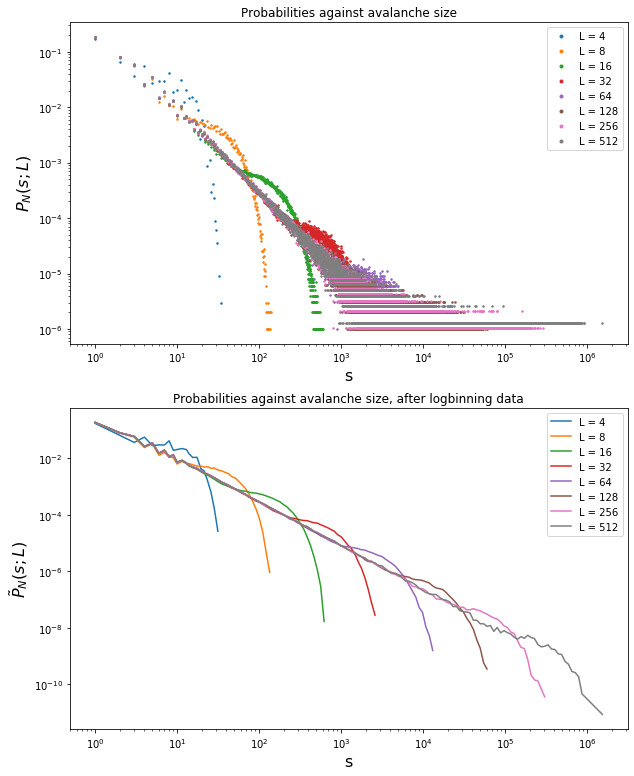

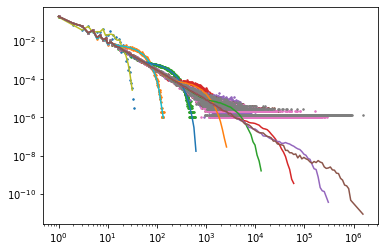

In [1018]:
from logbin230119 import logbin

avalanches = [x.get_avalanches_crossed() for x in Oslo_models]

# Setting scale to 1. returns the unbinned data, as del_s_j factor reduces to 1
probs_unbinned = [(logbin(data = avalanches[i], scale = 1,zeros = False)) for i in range(len(avalanches))]

# Log-bin to scale =1.1
probs_binned = [(logbin(data = avalanches[i], scale = 1.1,zeros = False)) for i in range(len(avalanches))]

# Plot
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (10,13))

[ax1.loglog(*probs_unbinned[i],'o',label = "L = {}".format(sizes[i]),ms = 1.5) for i in range(len(avalanches))]
ax1.set_title("Probabilities against avalanche size")
ax1.set_xlabel ("s",fontsize = 16)
ax1.set_ylabel(r"$P_N(s;L)$",fontsize = 16)
ax1.legend(markerscale = 2)

[ax2.loglog(*probs_binned[i],label = "L = {}".format(sizes[i])) for i in range(len(avalanches))]
ax2.set_title("Probabilities against avalanche size, after logbinning data")
ax2.set_xlabel ("s",fontsize = 16)
ax2.set_ylabel(r"$\tildeP_N(s;L)$",fontsize = 16)
ax2.legend()

#### Notes on Log-binning

Smaller system sizes have boundary effects, causing zigzag 

odd avalanches more likley, even avalanches less less likely

* For unbinned data, can see that cutoff only begins to show for large N, i.e. by increasing the statistics
* Log binning reduces noises for large s
* Approximates probability well
* But lose information on the avalanche, just know it is somwhere in the interval, not exactly where
* And there is no exact correspondance between P and P^~, just approximates to rid the noise.

### Task 3b: Scaling Ansatz Collapse

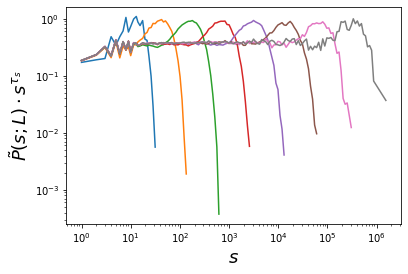

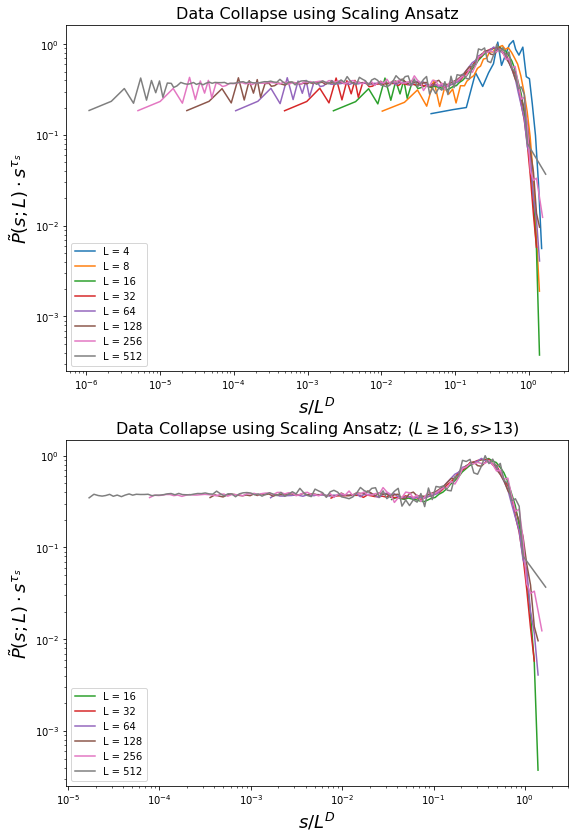

In [1137]:
# Estimate Values
D = 2.20
tau_s = 1.5555555

# Scale value by ansatz tfor data collapse
y = [probs_binned[i][1] * probs_binned[i][0]**(tau_s) for i in range(len(probs_binned))]
x = [probs_binned[i][0] for i in range(len(probs_binned))]
[plt.loglog(x[i],y[i]) for i in range(len(x))]
plt.xlabel("$s$",fontsize = 18)
plt.ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)


fig,(ax1,ax2) = plt.subplots(2,1, figsize = (9,14))

x = [probs_binned[i][0] / sizes[i]**D for i in range(len(probs_binned))]
[ax1.loglog(x[i],y[i],label = "L = {}".format(sizes[i]),color = "C{}".format(i)) for i in range(len(x))]
ax1.set_title(r"Data Collapse using Scaling Ansatz".format(tau_s,D),
         fontsize = 16)
ax1.set_xlabel("$s/ L^D$",fontsize = 18)
ax1.set_ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)
ax1.legend()


idx = 13 #Avalanche size index
[ax2.loglog(x[i][idx:],y[i][idx:],label = "L = {}".format(sizes[i]),color = "C{}".format(i)) for i in range(2,len(x))]
ax2.set_title(r"Data Collapse using Scaling Ansatz; ($L\geq 16,s$>$ 13$)".format(tau_s,D),
         fontsize = 16)
ax2.set_xlabel("$s/ L^D$",fontsize = 18)
ax2.set_ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)
plt.legend()

### Task 3c: Moments

Assuming the FSS ansatz is valid for all avalanche sizes \(s\) and approximating the sum with an integral, we find the \(k\) th moment:

$$
\begin{aligned}
&\left\langle s^{k}\right\rangle=\sum_{s=1}^{\infty} s^{k} P(s ; L)\\
&=\sum_{s=1}^{\infty} s^{k-\tau_{s}} \mathcal{G}\left(s / L^{D}\right) \quad \text { using FSS scaling ansatz, ignoring } a, b\\
&\propto \int_{1}^{\infty} s^{k-\tau_{s}} \mathcal{G}\left(s / L^{D}\right) d s \quad \text { assume main contribution is from } s \gg 1\\
&=\int_{1 / L^{0}}^{\infty}\left(L^{D} u\right)^{k-\tau_{s}} \mathcal{G}(u) L^{D} d u \quad \text { change variable } u=s / L^{D} \Leftrightarrow s=L^{D} u\\
&=L^{D\left(1+k-\tau_{s}\right)} \int_{1 / L^{D}}^{\infty} u^{k-\tau_{s}} \mathcal{G}(u) d u\\
&=L^{D\left(1+k-\tau_{s}\right)} \underbrace{\int_{0}^{\infty} u^{k-\tau_{s}} \mathcal{G}(u) d u}_{\text {Just a (finite) number if } 1+k-\tau_{s}>0} \text { for } L \gg 1
\end{aligned}
$$


In [1033]:
k_mom = [1,2,3,4]
moments = [x.get_k_moment() for x in Oslo_models]

# Obtain value for k_th moment from each Oslo model size
k_1 = [moments[i][0] for i in range(len(moments))]
k_2 = [moments[i][1] for i in range(len(moments))]
k_3 = [moments[i][2] for i in range(len(moments))]
k_4 = [moments[i][3] for i in range(len(moments))]

# Function for exponent
def X(k,D = 2.25,tau_s=1.55555):
    return D*(1+k-tau_s)

# Form moments into a list
k_s = [k_1,k_2,k_3,k_4]

# Prepare lists
gradients = []
ints = []

# Index to pick points to fit, ignore L = 4,8
sub = 2

# Fit line f best fits
for i in range(len(k_s)):
    m,c,a,a,a = stats.linregress(np.log10(sizes)[sub:],np.log10(k_s[i])[sub:])
    gradients.append(m)
    ints.append(c)
slope,intercept,a,b,c = stats.linregress([1,2,3,4],gradients)

# Calculate D and tau values. 
D = slope
tau_s = 1 - intercept/D
print("Tau_s = {:.4f}, D = {:.4f}".format(tau_s,D))

# Demonstrate corrections to scaling,
# Average S^k value / L^X
s_scaled = [np.array(k_s[i])/(np.array(sizes)**X(np.array(k_mom[i]),D,tau_s))for i in range(len(k_mom))]

# Average S^k value / L^X using ideal D and tau values
s_ideal = [np.array(k_s[i])/(np.array(sizes)**X(np.array(k_mom[i])))for i in range(len(k_mom))]

# Average S^k value / L^X adjusted to find scaling exponent
B_k = (np.array([s[-1] for s in s_ideal]))
print("b_0 values",B_k)
s_adjusted = [s_ideal[i] / B_k[i] - 1 for i in range(len(B_k))]

m,c,a,a,a = stats.linregress(np.log10(sizes)[sub:],np.log10(s_adjusted[i])[sub:])

# print(s_adjusted)



Tau_s = 1.5549, D = 2.2149
b_0 values [0.99548107 0.22348067 0.08417658 0.04086844]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


In [1031]:
idx = len(sizes) -3

grads = []
ints_1 = []
samp_x = np.arange(1,550,1)
for i in range(len(s_adjusted)):
    # apply idx to ignore the large L where scaling correction is not needed
    m,c,a,a,a = stats.linregress(np.log10(sizes)[:idx],np.log10(s_adjusted[i][:idx]))
    grads.append(m)
    ints_1.append(c)
print("Moment Scaling Exponent to first order (gamma): ",[grads])

Moment Scaling Exponent to first order (gamma):  [[-0.011185208895566519, -0.986990120960692, -1.1241234651553371, -1.3098797879077158]]


[[<matplotlib.lines.Line2D at 0x1bfda24510>],

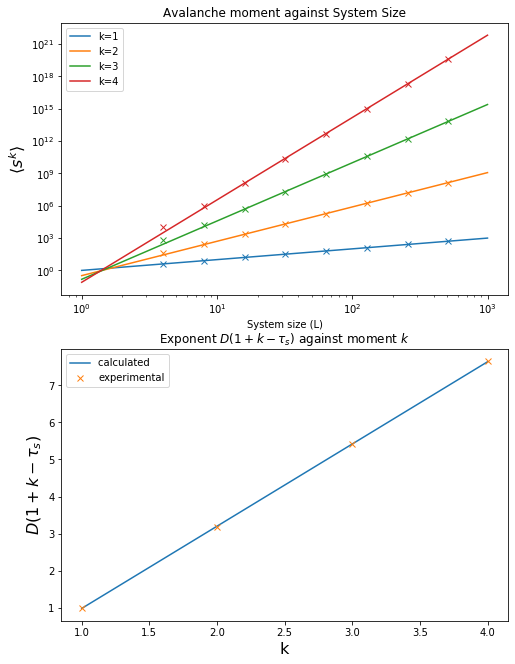

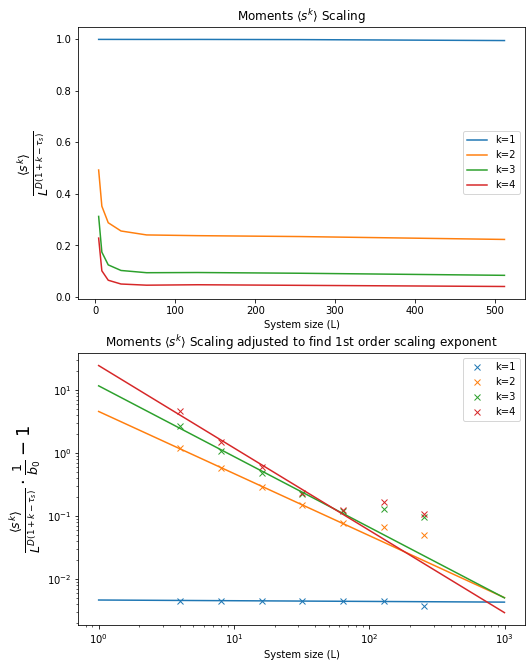

In [1036]:
# Plot
samp_x = (np.arange(1,1000,1))

fig,(ax1,ax2)= plt.subplots(2,1,figsize = (8,11))
fig,(ax3,ax4)= plt.subplots(2,1,figsize = (8,11))


[ax1.loglog(sizes,k_s[i],'x')for i in range(len(k_s))]
[ax1.loglog(samp_x,samp_x**gradients[i]*10**ints[i],color = "C{}".format(i),
           label = "k={}".format([1,2,3,4][i])) for i in range(len(ints))]
ax1.set_xlabel("System size (L)")
ax1.set_ylabel(r"$\langle s^k\rangle $",fontsize = 16)
ax1.set_title("Avalanche moment against System Size")
ax1.legend()

ax2.set_title(r"Exponent $D(1+k-\tau_s)$ against moment $k$")
ax2.plot([1,2,3,4],X(np.array([1,2,3,4]),D,tau_s),label = "calculated ")
ax2.plot([1,2,3,4],gradients,'x',label = "experimental")
ax2.legend()
ax2.set_xlabel("k",fontsize = 16)
ax2.set_ylabel(r"$D(1+k-\tau_s)$",fontsize = 16)

[ax3.plot(sizes,s_ideal[i],label = "k={}".format(k_mom[i]))for i in range(len(s_ideal))]
ax3.set_title(r"Moments $\langle s^k \rangle$ Scaling")
ax3.set_ylabel(r"$\frac{\langle s^k \rangle}{L^{D(1+k-\tau_s)}}$",fontsize =18)
ax3.set_xlabel("System size (L)",fontsize =10)
ax3.legend()

[ax4.loglog(sizes,s_adjusted[i],'x',label = "k={}".format(k_mom[i]))for i in range(len(s_adjusted))]
ax4.set_title(r"Moments $\langle s^k \rangle$ Scaling adjusted to find 1st order scaling exponent")
ax4.set_ylabel(r"$\frac{\langle s^k \rangle}{L^{D(1+k-\tau_s)}} \cdot \frac{1}{b_0} -1$",fontsize =18)
ax4.set_xlabel("System size (L)",fontsize =10)
ax4.legend()
[ax4.loglog(samp_x,samp_x**grads[i]*10**ints_1[i],color = "C{}".format(i)) for i in range(len(s_adjusted))]


#### Investigating additional correction dependencies

B_0 values [0.99548107 0.22348067 0.08417658 0.04086844]
gamma_1 values [-0.011185208895566519, -0.986990120960692, -1.1241234651553371, -1.3098797879077158]


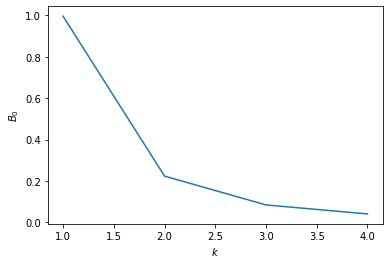

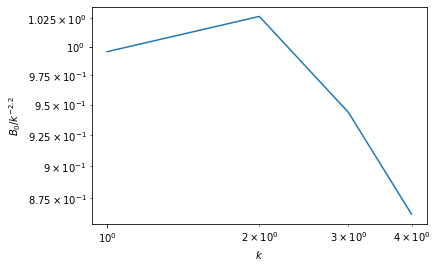

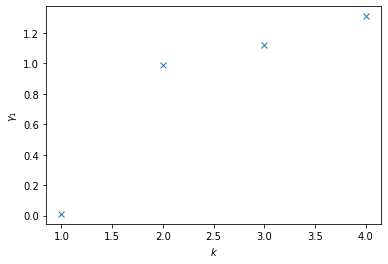

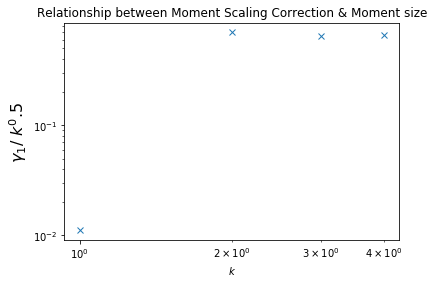

In [1131]:
ks = np.array(k_mom)

plt.figure()
plt.plot(ks,B_k)
plt.ylabel("$B_0$")
plt.xlabel("$k$")

plt.figure()
plt.loglog(ks,B_k/ks**-2.2)
plt.ylabel("$B_0$/$k^{-2.2}$")
plt.xlabel("$k$")

plt.figure()
plt.plot(ks,-np.array(grads),'x')
plt.xlabel("$k$")
plt.ylabel("$\gamma_1$")

plt.figure()
plt.loglog(ks,-np.array(grads)/ks**0.5,'x')
plt.xlabel("$k$")
plt.ylabel(r"$\gamma_1$/ $k^0.5$",fontsize = 16)
plt.title("Relationship between Moment Scaling Correction & Moment size")
final_m,final_c,a,a,a = stats.linregress([2,3,4],-np.array(grads[1:]))

print("B_0 values",B_k)
print("gamma_1 values",grads)

# print(final_m,final_c)
# print('Factor(y) = {:.4f}k + {:.4f}'.format(final_m,final_c))

Currently, can only conclude that $\gamma$ and $b_0$ depend on k on roughly a power law, which should have additional variables. However this was not further investigated as seemed out of the scope! (and limited by 2500 words.)

## Additional Notes

#### Machine Epsilon
Jupyter Notebook works in 32-bit, need to change certain calculations to 64-bit as machine epsilon is too small causing overflow errors

In [ ]:
print("32-bit Machine Epsilon:",np.finfo(float).eps)

#### Random Function Efficiency Test

In [ ]:
import timeit

mysetup = """
import numpy as np
import random
L =100
prob = [0.5,0.5]
z_ths = [1,2]
"""
mycode = "np.random.choice(z_ths,p=prob)"
print("Numpy Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

mycode = "random.choice(z_ths)"
print("Inbuilt Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")